# Residual Load from Weather

Weather → Power Fundamentals → Price: DK1

EnergiDataService and DMI API

Derive approximate wind/solar production

Build residual load = Load - WindPower - Solar Power

Relate to day-ahead prices

In [1]:
!pip install pandas numpy requests matplotlib scikit-learn xgboost

In [97]:
# imports

import pandas as pd
import numpy as np
import requests
import json
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb


In [99]:
# Define range
start = "2021-01-01T00:00"
end   = "2023-12-31T23:00"

## 1. Data fetching & Wrangling

### 1.1 EnergiDataService

In [33]:
# Fetch production

EDS_BALANCE = "https://api.energidataservice.dk/dataset/ElectricityBalanceNonv"

params = {
    "start": start,
    "end": end,
    "filter": '{"PriceArea":["DK1"]}',
    "limit": 200000
}

r = requests.get(EDS_BALANCE, params=params)
data = r.json()["records"]

df_bal = pd.DataFrame(data)


In [7]:
df_bal["HourUTC"] = pd.to_datetime(df_bal["HourUTC"], utc=True)
df_bal = df_bal.sort_values("HourUTC")
df_bal = df_bal.set_index("HourUTC")

In [13]:
df_power = df_bal[[
    "TotalLoad",
    "OffshoreWindPower",
    "OnshoreWindPower",
    "SolarPower"
]].astype(float)

df_power["Wind"] = df_power["OffshoreWindPower"] + df_power["OnshoreWindPower"]

df_power["ResidualLoad"] = (
    df_power["TotalLoad"]
    - df_power["Wind"]
    - df_power["SolarPower"]
)

In [ ]:
# Fetch Day-Ahead prices

EDS_PRICE = "https://api.energidataservice.dk/dataset/Elspotprices"

params = {
    "start": start,
    "end": end,
    "filter": '{"PriceArea":["DK1"]}',
    "limit": 200000
}

r = requests.get(EDS_PRICE, params=params)
j = r.json()
print("Status:", r.status_code, "Total records:", j.get("total"))

df_price = pd.DataFrame(j["records"])

In [28]:
df_price["HourUTC"] = pd.to_datetime(df_price["HourUTC"], utc=True)
df_price = df_price.sort_values("HourUTC").set_index("HourUTC")

df_price = df_price.rename(columns={"SpotPriceEUR": "DayAheadPrice"})
df_price = df_price[["DayAheadPrice"]].astype(float)

In [30]:
# Merge datasets

df = df_power.join(df_price, how="inner")
df = df.asfreq("H")
df = df.interpolate()


/tmp/ipython-input-1575457360.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


### 1.2 DMI - frie data

In [43]:
# Define a function to fetch DK1 Weather observations

OBS_URL = "https://opendataapi.dmi.dk/v2/metObs/collections/observation/items"

def fetch_param_series(parameter_id, start, end, col_name, bbox="7,54,11.3,58"):
    params = {
        "datetime": f"{start}/{end}",
        "bbox": bbox,
        "parameterId": parameter_id,
        "limit": 300000
    }
    resp = requests.get(OBS_URL, params=params)
    print(f"{parameter_id} status:", resp.status_code)

    if resp.status_code != 200:
        print("Body snippet:", resp.text[:300])
        return pd.DataFrame(columns=[col_name])

    js = resp.json()
    feats = js.get("features", [])
    if not feats:
        print(f"No features returned for {parameter_id}")
        return pd.DataFrame(columns=[col_name])

    recs = []
    for f in feats:
        props = f["properties"]
        recs.append({
            "time": props["observed"],
            "value": props["value"]
        })

    df = pd.DataFrame(recs)
    df["time"] = pd.to_datetime(df["time"], utc=True)
    df = df.set_index("time").sort_index()
    df = df.resample("H").mean()
    df = df.rename(columns={"value": col_name})
    return df

In [ ]:
# Create final weather observation dataset

df_ws  = fetch_param_series("wind_speed_past1h",  start, end, "WindSpeed")
df_rad = fetch_param_series("radia_glob_past1h",  start, end, "GlobalRadiation")
df_tmp = fetch_param_series("temp_mean_past1h",   start, end, "Temperature")

df_weather = df_ws.join([df_rad, df_tmp], how="outer")
df_weather = df_weather.interpolate()

# Merge power and weather datasets

df_full = df_power.join(df_weather, how="inner")

## Modelling

Define feature set and target

In [ ]:
df = df_full
df = df.sort_index()

In [61]:
data = df.copy()

# Calendar features
data["hour"] = data.index.hour
data["dow"] = data.index.dayofweek   # 0=Mon
data["month"] = data.index.month

# Lag feature: yesterday same hour
data["ResidualLoad_lag24"] = data["ResidualLoad"].shift(24)

# Drop first 24 hours where lag is NaN
data = data.dropna(subset=["ResidualLoad_lag24"])

In [62]:
feature_cols_numeric = ["WindSpeed", "GlobalRadiation", "Temperature", "ResidualLoad_lag24"]
feature_cols_cat = ["hour", "dow", "month"]

X_num = data[feature_cols_numeric]

X_cat = pd.get_dummies(
    data[feature_cols_cat].astype("category"),
    drop_first=True
)

X = pd.concat([X_num, X_cat], axis=1)
y = data["ResidualLoad"]

In [63]:
split_date = "2023-01-01"

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test  = X[X.index >= split_date]
y_test  = y[y.index >= split_date]

X_train.shape, X_test.shape


((17494, 44), (8757, 44))

In [64]:
y_pred_baseline = data.loc[y_test.index, "ResidualLoad_lag24"]

## Predicting

Create prediction set

In [67]:
# Baseline naive model: “yesterday’s hour”

def eval_model(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}  |  MAE: {mae:,.1f} MW   RMSE: {rmse:,.1f} MW")

eval_model(y_test, y_pred_baseline, "Baseline (RL_t-24)")

Baseline (RL_t-24)  |  MAE: 1,038.4 MW   RMSE: 1,338.1 MW


In [68]:
# Linear model: ridge regression

ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
eval_model(y_test, y_pred_ridge, "Ridge")


Ridge  |  MAE: 504.2 MW   RMSE: 660.3 MW


In [70]:
# Nonlinear model: Random Forest

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
eval_model(y_test, y_pred_rf, "Random Forest")


Random Forest  |  MAE: 495.6 MW   RMSE: 629.2 MW


In [79]:
# Nonlinear model: Xgboost

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.08,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42,
}

evals = [(dtrain, "train"), (dtest, "test")]

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=400,
    evals=evals,
    verbose_eval=50   # prints RMSE every 50 rounds
)

y_pred_xgb = model_xgb.predict(dtest)
eval_model(y_test, y_pred_xgb, "XGBoost")


[0]	train-rmse:979.82195	test-rmse:1159.58476
[50]	train-rmse:380.48108	test-rmse:622.74714
[100]	train-rmse:331.59117	test-rmse:613.19285
[150]	train-rmse:301.37645	test-rmse:616.53791
[200]	train-rmse:277.28706	test-rmse:619.71336
[250]	train-rmse:256.91919	test-rmse:621.25422
[300]	train-rmse:240.26788	test-rmse:623.23798
[350]	train-rmse:225.72691	test-rmse:624.56370
[399]	train-rmse:212.84877	test-rmse:625.52360
XGBoost  |  MAE: 486.6 MW   RMSE: 625.5 MW


In [82]:
# Export the model’s predictions for price work

df_res_model = pd.DataFrame({
    "ResidualLoad_actual": y_test,
    "ResidualLoad_baseline": y_pred_baseline,
    "ResidualLoad_ridge": y_pred_ridge,
    "ResidualLoad_rf": y_pred_rf,
    "ResidualLoad_xgb": y_pred_xgb
})

## Price work

In [100]:
ELSPOT = "https://api.energidataservice.dk/dataset/elspotprices"

params = {
    "start": start,
    "end": end,
    "filter": '{"PriceArea":["DK1"]}',
    "limit": 200000
}
df_price = pd.DataFrame(requests.get(ELSPOT, params=params).json()["records"])

df_price["HourUTC"] = pd.to_datetime(df_price["HourUTC"], utc=True)
df_price = df_price.sort_values("HourUTC").set_index("HourUTC")

df_price = df_price.rename(columns={"SpotPriceEUR": "ElspotPrice"})
df_price = df_price[["ElspotPrice"]].astype(float)


In [ ]:
df_power = df_power.join(df_price, how="inner")
df_full = df_power.join(df_weather, how="inner")

In [109]:
# Check they cover the same 2023 period
df_2023 = df_full["2023-01-01":"2023-12-31"].copy()

# Join predictions onto the main frame (index = HourUTC)
df_2023 = df_2023.join(df_pred, how="inner")
df_2023.head()

,TotalLoad,OffshoreWindPower,OnshoreWindPower,SolarPower,Wind,ResidualLoad,ElspotPrice,WindSpeed,GlobalRadiation,Temperature,ResidualLoad_actual,ResidualLoad_baseline,ResidualLoad_ridge,ResidualLoad_rf,ResidualLoad_xgb
2023-01-01 00:00:00+00:00,2122.850098,350.619995,781.760010,0.43,1132.380005,990.040093,1.38,1.783333,0.0,4.608333,990.040093,-961.969927,1470.183106,1667.078252,1587.426392
2023-01-01 01:00:00+00:00,2127.719971,314.940002,834.289978,0.42,1149.229980,978.069991,0.09,1.925000,0.0,4.550000,978.069991,-829.899920,1297.544230,1665.786174,1433.262451
2023-01-01 02:00:00+00:00,2026.239990,302.829987,855.010010,0.43,1157.839997,867.969993,0.08,2.200000,0.0,4.441667,867.969993,-868.009966,1203.876290,1469.703712,1319.248291
2023-01-01 03:00:00+00:00,1985.670044,213.720001,916.400024,0.43,1130.120025,855.120019,0.05,2.666667,0.0,4.341667,855.120019,-833.509966,1093.670502,1237.607538,1029.633301
2023-01-01 04:00:00+00:00,1974.770020,43.619999,880.780029,0.43,924.400028,1049.939992,0.00,2.816667,0.0,4.091667,1049.939992,-751.019985,1191.870675,1162.390712,1015.833252


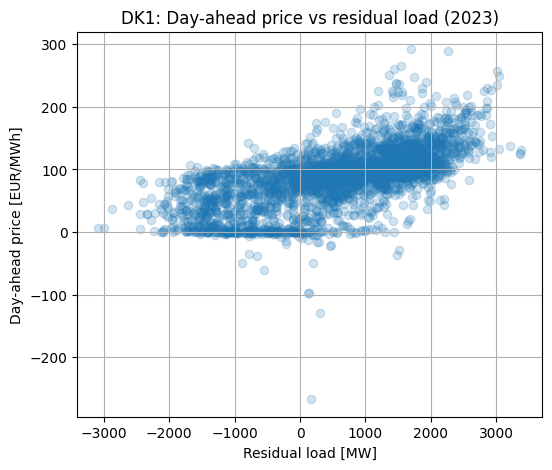

In [111]:
sample = df_2023.sample(3000, random_state=42)  # avoid plotting all points if huge

plt.figure(figsize=(6,5))
plt.scatter(sample["ResidualLoad"], sample["ElspotPrice"], alpha=0.2)
plt.xlabel("Residual load [MW]")
plt.ylabel("Day-ahead price [EUR/MWh]")
plt.title("DK1: Day-ahead price vs residual load (2023)")
plt.grid(True)
plt.show()


In [121]:
#df_train = df_train.join(df_price, how="inner")
#df_test = df_test.join(df_price, how="inner")

In [126]:
df_train = df_full.loc["2021-01-01":"2022-12-31"].copy()
df_test  = df_2023.copy()  # already filtered

def make_features_price(d):
    out = pd.DataFrame(index=d.index)
    out["ResidualLoad"] = d["ResidualLoad"]
    out["hour"] = d.index.hour
    out["dow"] = d.index.dayofweek
    out["month"] = d.index.month
    return out

X_train_p = make_features_price(df_train)
y_train_p = df_train["ElspotPrice"]

X_test_p_actual = make_features_price(df_test)   # will later swap RL with forecast
y_test_p = df_test["ElspotPrice"]

# One-hot encode calendar
X_train_p_cat = pd.get_dummies(
    X_train_p[["hour","dow","month"]].astype("category"),
    drop_first=True
)
X_test_p_cat = pd.get_dummies(
    X_test_p_actual[["hour","dow","month"]].astype("category"),
    drop_first=True
)

# Align columns to be safe
X_train_p_full = pd.concat([X_train_p[["ResidualLoad"]], X_train_p_cat], axis=1)
X_test_p_full  = pd.concat([X_test_p_actual[["ResidualLoad"]], X_test_p_cat], axis=1)
X_test_p_full = X_test_p_full.reindex(columns=X_train_p_full.columns, fill_value=0)


In [129]:
lin_price = LinearRegression()
lin_price.fit(X_train_p_full, y_train_p)

y_pred_price_oracle = lin_price.predict(X_test_p_full)

In [132]:

def eval_price(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)   # this is the correct new function
    # or: rmse = mean_squared_error(y_true, y_pred, squared=False)  # old way, removed
    print(f"{name}  |  MAE: {mae:,.2f} €/MWh   RMSE: {rmse:,.2f} €/MWh")

eval_price(y_test_p, y_pred_price_oracle, "Price model (oracle RL)")


Price model (oracle RL)  |  MAE: 74.48 €/MWh   RMSE: 94.08 €/MWh


In [133]:
# Replace actual residual load with forecast residual load

# Start from same X_test_p_actual but swap RL column
X_test_p_xgb = X_test_p_actual.copy()
X_test_p_xgb["ResidualLoad"] = df_test["ResidualLoad_xgb"]  # or your chosen model

X_test_p_xgb_cat = pd.get_dummies(
    X_test_p_xgb[["hour","dow","month"]].astype("category"),
    drop_first=True
)

X_test_p_xgb_full = pd.concat(
    [X_test_p_xgb[["ResidualLoad"]], X_test_p_xgb_cat],
    axis=1
)
X_test_p_xgb_full = X_test_p_xgb_full.reindex(columns=X_train_p_full.columns, fill_value=0)

y_pred_price_xgb = lin_price.predict(X_test_p_xgb_full)
eval_price(y_test_p, y_pred_price_xgb, "Price model (XGBoost RL forecast)")


Price model (XGBoost RL forecast)  |  MAE: 78.78 €/MWh   RMSE: 98.23 €/MWh


In [135]:
results = {}

for name, col in [
    ("Actual RL (oracle)", "ResidualLoad"),
    ("Baseline RL(t-24)", "ResidualLoad_baseline"),
    ("Ridge RL", "ResidualLoad_ridge"),
    ("RF RL", "ResidualLoad_rf"),
    ("XGB RL", "ResidualLoad_xgb"),
]:
    X_test_p_tmp = X_test_p_actual.copy()
    X_test_p_tmp["ResidualLoad"] = df_test[col]

    X_test_p_tmp_cat = pd.get_dummies(
        X_test_p_tmp[["hour","dow","month"]].astype("category"),
        drop_first=True
    )

    X_test_p_tmp_full = pd.concat(
        [X_test_p_tmp[["ResidualLoad"]], X_test_p_tmp_cat],
        axis=1
    )
    X_test_p_tmp_full = X_test_p_tmp_full.reindex(columns=X_train_p_full.columns, fill_value=0)

    y_pred_tmp = lin_price.predict(X_test_p_tmp_full)
    mae = mean_absolute_error(y_test_p, y_pred_tmp)
    rmse = np.sqrt(mean_squared_error(y_test_p, y_pred_tmp))  # <-- Fixed line

    results[name] = (mae, rmse)

results

{'Actual RL (oracle)': (74.47720718858011, np.float64(94.08396555204448)),
 'Baseline RL(t-24)': (78.47877745222422, np.float64(98.75176935420272)),
 'Ridge RL': (78.31792211731809, np.float64(97.61432283485286)),
 'RF RL': (78.77123660269098, np.float64(98.24988915230135)),
 'XGB RL': (78.78468420371048, np.float64(98.22644862500775))}

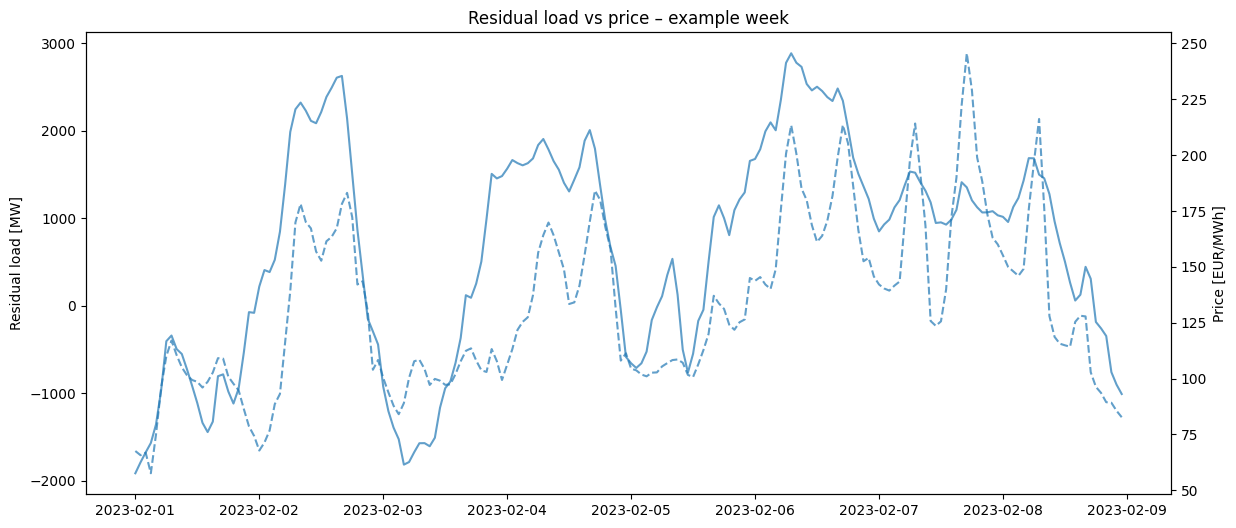

In [137]:
period = slice("2023-02-01", "2023-02-08")

plt.figure(figsize=(14,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_2023.loc[period].index,
         df_2023.loc[period, "ResidualLoad"],
         label="Residual load", alpha=0.7)
ax2.plot(df_2023.loc[period].index,
         df_2023.loc[period, "ElspotPrice"],
         label="Day-ahead price", alpha=0.7, linestyle="--")

ax1.set_ylabel("Residual load [MW]")
ax2.set_ylabel("Price [EUR/MWh]")
plt.title("Residual load vs price – example week")
plt.show()


In [139]:
y_pred_price_xgb = pd.Series(
    y_pred_price_xgb,
    index=X_test_p_xgb_full.index,
    name="Price_pred_xgb"
)


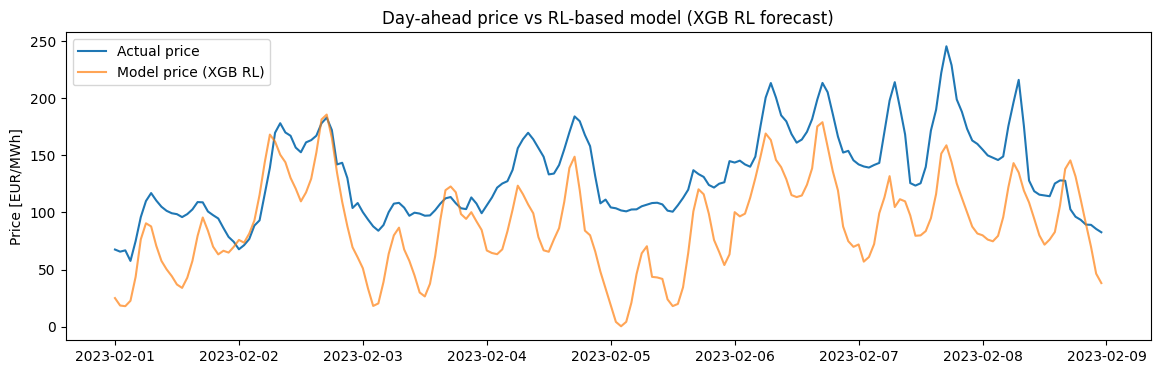

In [140]:
period = slice("2023-02-01", "2023-02-08")

plt.figure(figsize=(14,4))
plt.plot(y_test_p.loc[period].index,
         y_test_p.loc[period],
         label="Actual price")

plt.plot(y_pred_price_xgb.loc[period].index,
         y_pred_price_xgb.loc[period],
         label="Model price (XGB RL)",
         alpha=0.7)

plt.ylabel("Price [EUR/MWh]")
plt.title("Day-ahead price vs RL-based model (XGB RL forecast)")
plt.legend()
plt.show()
